# OCR Baseline using LPRNet (PyTorch)

This notebook implements the OCR pipeline using **LPRNet**, a lightweight Convolutional Neural Network designed for License Plate Recognition.

**Optimized for A100 GPU:**
- **Batch Size**: 1024
- **Mixed Precision**: Enabled (AMP)
- **Workers**: 8
- **Progress Tracking**: TQDM enabled
- **Metrics**: Sequence Acc, Char Acc, Edit Distance

**Steps:**
1. **Setup**: Import libraries and Modules.
2. **Data**: Load dataset using custom `LPRDataset`.
3. **Model**: Initialize `LPRNet`.
4. **Training**: Train the model using CTC Loss with AMP.
5. **Inference**: Evaluate on validation set.

## 1. Setup

In [1]:
import os
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler # Mixed Precision
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm

# Add src to path if needed
sys.path.append('..')

from src.ocr.lprnet import build_lprnet
from src.ocr.reader import LPRDataset, collate_fn
from src.ocr.decoder import LPRLabelEncoder, CHARS
from src.evaluation.metrics import compute_ocr_metrics

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Check CUDA Capability
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Using device: cuda
GPU: NVIDIA A100-SXM4-80GB
Memory: 85.20 GB


## 2. Dataset Preparation

In [2]:
DATASET_DIR = "../datasets/preprocessed/plate_text_cropped"
IMAGES_DIR = os.path.join(DATASET_DIR, "dataset")
LABEL_FILE = os.path.join(DATASET_DIR, "label.csv")

# HPC Optimization
BATCH_SIZE = 16 # Increased for A100
NUM_WORKERS = 8   # Parallel data loading
PIN_MEMORY = True # Speed up host-to-device transfer

IMG_SIZE = (94, 24) # LPRNet standard input size

# Initialize Dataset
dataset = LPRDataset(img_dir=IMAGES_DIR, label_file=LABEL_FILE, img_size=IMG_SIZE)

# Split Dataset
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                          collate_fn=collate_fn, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                        collate_fn=collate_fn, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}")

Train samples: 1490, Val samples: 373


## 3. Model Initialization

In [3]:
lpr_max_len = 18 # Maximum length of license plate
class_num = len(CHARS) + 1 # +1 for blank

model = build_lprnet(lpr_max_len=lpr_max_len, class_num=class_num, dropout_rate=0.5)
model.to(device)
# print(model) # Commented out to reduce log clutter

LPRNet(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=0, dilation=1, ceil_mode=False)
    (4): SmallBasicBlock(
      (block): Sequential(
        (0): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
        (1): ReLU()
        (2): Conv2d(32, 32, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
        (3): ReLU()
        (4): Conv2d(32, 32, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
        (5): ReLU()
        (6): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool3d(kernel_size=(1, 3, 3), stride=(2, 1, 2), padding=0, dilation=1, ceil_mode=False)
    (8): SmallBasicBlock(
      (block): Sequential(
        (0): Conv2d(64, 64, kern

## 4. Training Loop (with AMP & TQDM)

In [4]:
num_epochs = 100
patience = 15                # Early stopping patience
best_seq_acc = 0.0
epochs_no_improve = 0

save_dir = "../artifacts/lprnet"
os.makedirs(save_dir, exist_ok=True)


criterion = nn.CTCLoss(blank=len(CHARS), reduction='mean')

optimizer = optim.Adam(
    model.parameters(),
    lr=0.001
)

scheduler = optim.lr_scheduler.StepLR(
    optimizer,
    step_size=20,
    gamma=0.5
)

scaler = GradScaler()


def train_one_epoch(model, loader, optimizer, criterion, device, scaler, epoch):
    model.train()
    total_loss = 0.0

    pbar = tqdm(loader, desc=f"Train Epoch {epoch+1}", leave=False)

    for images, labels, lengths in pbar:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        lengths = lengths.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        with autocast():
            logits = model(images)                 # (B, C, T)
            log_probs = logits.permute(2, 0, 1)    # (T, B, C)
            log_probs = log_probs.log_softmax(2)

            input_lengths = torch.full(
                size=(images.size(0),),
                fill_value=logits.size(2),
                dtype=torch.long,
                device=device
            )

            loss = criterion(log_probs, labels, input_lengths, lengths)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        pbar.set_postfix(loss=f"{loss.item():.4f}")

    return total_loss / len(loader)

def evaluate(model, loader, device):
    model.eval()
    encoder = LPRLabelEncoder(CHARS)

    all_preds = []
    all_targets = []

    pbar = tqdm(loader, desc="Evaluating", leave=False)

    with torch.no_grad():
        for images, labels, lengths in pbar:
            images = images.to(device, non_blocking=True)

            with autocast():
                logits = model(images)

            preds = encoder.decode_greedy(logits)

            labels = labels.cpu().numpy()
            lengths = lengths.cpu().numpy()

            idx = 0
            for i, length in enumerate(lengths):
                true_indices = labels[idx : idx + length]
                true_text = "".join([CHARS[j] for j in true_indices])
                idx += length

                all_preds.append(preds[i])
                all_targets.append(true_text)

    metrics = compute_ocr_metrics(all_preds, all_targets)
    return metrics


print("Starting Training...\n")

for epoch in range(num_epochs):
    train_loss = train_one_epoch(
        model,
        train_loader,
        optimizer,
        criterion,
        device,
        scaler,
        epoch
    )

    scheduler.step()

    metrics = evaluate(model, val_loader, device)

    seq_acc = metrics["seq_acc"]
    char_acc = metrics["char_acc"]
    edit_dist = metrics["avg_edit_dist"]

    print(
        f"Epoch [{epoch+1}/{num_epochs}] "
        f"Loss: {train_loss:.4f} | "
        f"Seq Acc: {seq_acc:.4f} | "
        f"Char Acc: {char_acc:.4f} | "
        f"Edit Dist: {edit_dist:.4f}"
    )


    if seq_acc > best_seq_acc:
        best_seq_acc = seq_acc
        epochs_no_improve = 0

        torch.save(
            model.state_dict(),
            os.path.join(save_dir, "lprnet_best.pth")
        )
        print(f"Best model saved (Seq Acc: {best_seq_acc:.4f})")

    else:
        epochs_no_improve += 1


    if epochs_no_improve >= patience:
        print(f"\nEarly stopping triggered after {epoch+1} epochs")
        break


torch.save(
    model.state_dict(),
    os.path.join(save_dir, "lprnet_last.pth")
)

print("\nTraining finished")
print(f"Best Seq Accuracy: {best_seq_acc:.4f}")
print(f"Models saved in: {save_dir}")

Starting Training...



Epoch [1/100] Loss: 3.6143 | Seq Acc: 0.0000 | Char Acc: 0.0669 | Edit Dist: 6.8767


Epoch [2/100] Loss: 2.8377 | Seq Acc: 0.0000 | Char Acc: 0.2266 | Edit Dist: 5.6997


Epoch [3/100] Loss: 2.1462 | Seq Acc: 0.0080 | Char Acc: 0.3798 | Edit Dist: 4.5710
Best model saved (Seq Acc: 0.0080)


Epoch [4/100] Loss: 1.5196 | Seq Acc: 0.0483 | Char Acc: 0.5606 | Edit Dist: 3.2386
Best model saved (Seq Acc: 0.0483)


Epoch [5/100] Loss: 1.2173 | Seq Acc: 0.0938 | Char Acc: 0.5988 | Edit Dist: 2.9571
Best model saved (Seq Acc: 0.0938)


Epoch [6/100] Loss: 1.1012 | Seq Acc: 0.1903 | Char Acc: 0.6802 | Edit Dist: 2.3566
Best model saved (Seq Acc: 0.1903)


Epoch [7/100] Loss: 0.9767 | Seq Acc: 0.1501 | Char Acc: 0.6650 | Edit Dist: 2.4692


Epoch [8/100] Loss: 0.9306 | Seq Acc: 0.2332 | Char Acc: 0.7272 | Edit Dist: 2.0107
Best model saved (Seq Acc: 0.2332)


Epoch [9/100] Loss: 0.7947 | Seq Acc: 0.2413 | Char Acc: 0.7370 | Edit Dist: 1.9383
Best model saved (Seq Acc: 0.2413)


Epoch [10/100] Loss: 0.7507 | Seq Acc: 0.2627 | Char Acc: 0.7410 | Edit Dist: 1.9088
Best model saved (Seq Acc: 0.2627)


Epoch [11/100] Loss: 0.7167 | Seq Acc: 0.2815 | Char Acc: 0.7348 | Edit Dist: 1.9544
Best model saved (Seq Acc: 0.2815)


Epoch [12/100] Loss: 0.6965 | Seq Acc: 0.2038 | Char Acc: 0.7064 | Edit Dist: 2.1635


Epoch [13/100] Loss: 0.6726 | Seq Acc: 0.2735 | Char Acc: 0.7548 | Edit Dist: 1.8070


Epoch [14/100] Loss: 0.6419 | Seq Acc: 0.2145 | Char Acc: 0.7268 | Edit Dist: 2.0134


Epoch [15/100] Loss: 0.5900 | Seq Acc: 0.3244 | Char Acc: 0.7766 | Edit Dist: 1.6461
Best model saved (Seq Acc: 0.3244)


Epoch [16/100] Loss: 0.5389 | Seq Acc: 0.3164 | Char Acc: 0.7686 | Edit Dist: 1.7051


Epoch [17/100] Loss: 0.5278 | Seq Acc: 0.3244 | Char Acc: 0.7781 | Edit Dist: 1.6354


Epoch [18/100] Loss: 0.5153 | Seq Acc: 0.3753 | Char Acc: 0.7912 | Edit Dist: 1.5389
Best model saved (Seq Acc: 0.3753)


Epoch [19/100] Loss: 0.4561 | Seq Acc: 0.3539 | Char Acc: 0.7839 | Edit Dist: 1.5925


Epoch [20/100] Loss: 0.4661 | Seq Acc: 0.3753 | Char Acc: 0.8119 | Edit Dist: 1.3861


Epoch [21/100] Loss: 0.3549 | Seq Acc: 0.4209 | Char Acc: 0.8261 | Edit Dist: 1.2815
Best model saved (Seq Acc: 0.4209)


Epoch [22/100] Loss: 0.3604 | Seq Acc: 0.4450 | Char Acc: 0.8323 | Edit Dist: 1.2359
Best model saved (Seq Acc: 0.4450)


Epoch [23/100] Loss: 0.3095 | Seq Acc: 0.4692 | Char Acc: 0.8338 | Edit Dist: 1.2252
Best model saved (Seq Acc: 0.4692)


Epoch [24/100] Loss: 0.2765 | Seq Acc: 0.4558 | Char Acc: 0.8348 | Edit Dist: 1.2172


Epoch [25/100] Loss: 0.2834 | Seq Acc: 0.4531 | Char Acc: 0.8283 | Edit Dist: 1.2654


Epoch [26/100] Loss: 0.2735 | Seq Acc: 0.4772 | Char Acc: 0.8385 | Edit Dist: 1.1903
Best model saved (Seq Acc: 0.4772)


Epoch [27/100] Loss: 0.2755 | Seq Acc: 0.4209 | Char Acc: 0.8163 | Edit Dist: 1.3539


Epoch [28/100] Loss: 0.2594 | Seq Acc: 0.4718 | Char Acc: 0.8363 | Edit Dist: 1.2064


Epoch [29/100] Loss: 0.3043 | Seq Acc: 0.4531 | Char Acc: 0.8341 | Edit Dist: 1.2225


Epoch [30/100] Loss: 0.2469 | Seq Acc: 0.4584 | Char Acc: 0.8334 | Edit Dist: 1.2279


Epoch [31/100] Loss: 0.2232 | Seq Acc: 0.4665 | Char Acc: 0.8341 | Edit Dist: 1.2225


Epoch [32/100] Loss: 0.2250 | Seq Acc: 0.4558 | Char Acc: 0.8367 | Edit Dist: 1.2038


Epoch [33/100] Loss: 0.2071 | Seq Acc: 0.4906 | Char Acc: 0.8381 | Edit Dist: 1.1930
Best model saved (Seq Acc: 0.4906)


Epoch [34/100] Loss: 0.2029 | Seq Acc: 0.5067 | Char Acc: 0.8447 | Edit Dist: 1.1448
Best model saved (Seq Acc: 0.5067)


Epoch [35/100] Loss: 0.1960 | Seq Acc: 0.4611 | Char Acc: 0.8392 | Edit Dist: 1.1850


Epoch [36/100] Loss: 0.1867 | Seq Acc: 0.4236 | Char Acc: 0.8174 | Edit Dist: 1.3458


Epoch [37/100] Loss: 0.2012 | Seq Acc: 0.4665 | Char Acc: 0.8385 | Edit Dist: 1.1903


Epoch [38/100] Loss: 0.1976 | Seq Acc: 0.4799 | Char Acc: 0.8399 | Edit Dist: 1.1796


Epoch [39/100] Loss: 0.1826 | Seq Acc: 0.4718 | Char Acc: 0.8436 | Edit Dist: 1.1528


Epoch [40/100] Loss: 0.1650 | Seq Acc: 0.4799 | Char Acc: 0.8432 | Edit Dist: 1.1555


Epoch [41/100] Loss: 0.1338 | Seq Acc: 0.5174 | Char Acc: 0.8559 | Edit Dist: 1.0617
Best model saved (Seq Acc: 0.5174)


Epoch [42/100] Loss: 0.1149 | Seq Acc: 0.5040 | Char Acc: 0.8549 | Edit Dist: 1.0697


Epoch [43/100] Loss: 0.1230 | Seq Acc: 0.5335 | Char Acc: 0.8567 | Edit Dist: 1.0563
Best model saved (Seq Acc: 0.5335)


Epoch [44/100] Loss: 0.1018 | Seq Acc: 0.5282 | Char Acc: 0.8589 | Edit Dist: 1.0402


Epoch [45/100] Loss: 0.1167 | Seq Acc: 0.5201 | Char Acc: 0.8541 | Edit Dist: 1.0751


Epoch [46/100] Loss: 0.1567 | Seq Acc: 0.5255 | Char Acc: 0.8545 | Edit Dist: 1.0724


Epoch [47/100] Loss: 0.1097 | Seq Acc: 0.5255 | Char Acc: 0.8559 | Edit Dist: 1.0617


Epoch [48/100] Loss: 0.1117 | Seq Acc: 0.4879 | Char Acc: 0.8487 | Edit Dist: 1.1153


Epoch [49/100] Loss: 0.0914 | Seq Acc: 0.5416 | Char Acc: 0.8603 | Edit Dist: 1.0295
Best model saved (Seq Acc: 0.5416)


Epoch [50/100] Loss: 0.0885 | Seq Acc: 0.5228 | Char Acc: 0.8592 | Edit Dist: 1.0375


Epoch [51/100] Loss: 0.0991 | Seq Acc: 0.5255 | Char Acc: 0.8570 | Edit Dist: 1.0536


Epoch [52/100] Loss: 0.0916 | Seq Acc: 0.5121 | Char Acc: 0.8545 | Edit Dist: 1.0724


Epoch [53/100] Loss: 0.0861 | Seq Acc: 0.5282 | Char Acc: 0.8614 | Edit Dist: 1.0214


Epoch [54/100] Loss: 0.0831 | Seq Acc: 0.5362 | Char Acc: 0.8570 | Edit Dist: 1.0536


Epoch [55/100] Loss: 0.0825 | Seq Acc: 0.5147 | Char Acc: 0.8523 | Edit Dist: 1.0885


Epoch [56/100] Loss: 0.0825 | Seq Acc: 0.5228 | Char Acc: 0.8530 | Edit Dist: 1.0831


Epoch [57/100] Loss: 0.0863 | Seq Acc: 0.5255 | Char Acc: 0.8545 | Edit Dist: 1.0724


Epoch [58/100] Loss: 0.0872 | Seq Acc: 0.4906 | Char Acc: 0.8530 | Edit Dist: 1.0831


Epoch [59/100] Loss: 0.0806 | Seq Acc: 0.5174 | Char Acc: 0.8574 | Edit Dist: 1.0509


Epoch [60/100] Loss: 0.0837 | Seq Acc: 0.5228 | Char Acc: 0.8570 | Edit Dist: 1.0536


Epoch [61/100] Loss: 0.0619 | Seq Acc: 0.5335 | Char Acc: 0.8607 | Edit Dist: 1.0268


Epoch [62/100] Loss: 0.0564 | Seq Acc: 0.5282 | Char Acc: 0.8585 | Edit Dist: 1.0429


Epoch [63/100] Loss: 0.0570 | Seq Acc: 0.5389 | Char Acc: 0.8643 | Edit Dist: 1.0000


Epoch [64/100] Loss: 0.0791 | Seq Acc: 0.5121 | Char Acc: 0.8556 | Edit Dist: 1.0643

Early stopping triggered after 64 epochs

Training finished
Best Seq Accuracy: 0.5416
Models saved in: ../artifacts/lprnet


## 5. Inference Visualization

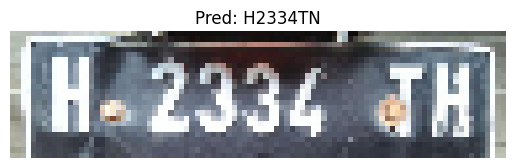

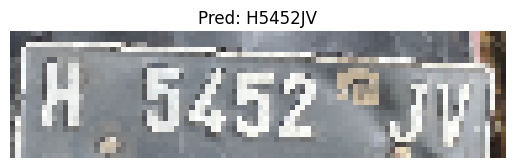

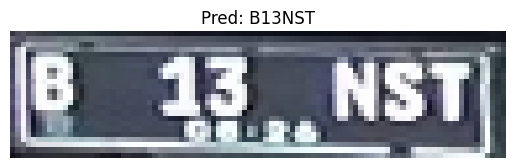

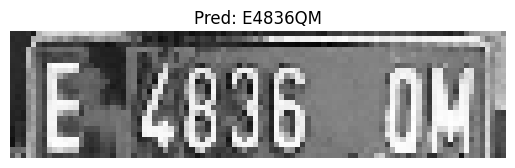

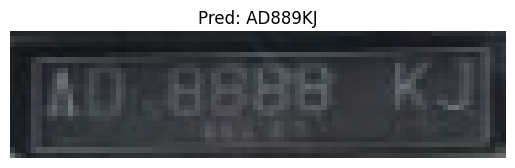

In [5]:
def show_results(model, dataset, num=5):
    model.eval()
    encoder = LPRLabelEncoder(CHARS)
    
    indices = np.random.randint(0, len(dataset), num)
    
    for idx in indices:
        img_tensor, _, _ = dataset[idx]
        input_img = img_tensor.unsqueeze(0).to(device)
        
        with torch.no_grad():
            logits = model(input_img)
            pred_text = encoder.decode_greedy(logits)[0]
            
        # De-normalize for plotting
        display_img = img_tensor.numpy().transpose(1, 2, 0)
        display_img = (display_img / 0.0078125) + 127.5
        display_img = display_img.astype(np.uint8)
        
        plt.figure()
        plt.imshow(cv2.cvtColor(display_img, cv2.COLOR_BGR2RGB))
        plt.title(f"Pred: {pred_text}")
        plt.axis('off')
        plt.show()

show_results(model, val_dataset)